In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: itsnaveenkroy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 484MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


## Preprocessing

In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis = 1, inplace=True)
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(data_df.shape)

(18185, 11)


In [7]:
print(data_df["Class"].unique())

[1 0]


In [8]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


## Normalization

In [9]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


## Splitting

In [10]:
X = np.array(data_df.iloc[:,:-1]) #inputs (all until)
y = np.array(data_df.iloc[:,-1])  #output (only that one)

## Training data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Validation for testing model

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


## Converting to pytorch data set object

In [14]:
class dataset(Dataset): #modifying 'Dataset' class as per out dataset
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.y = torch.tensor(y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

##This runs when you create the dataset object. It takes the data (X) and labels (y) and converts them into PyTorch tensors so the model can use them.

```
* torch.tensor() converts numpy arrays to tensors

* dtype=torch.float32 sets the type to 32-bit floats (needed for most models)

* .to(device) moves the data to CPU or GPU (wherever you're training)

```

In [15]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

##What is a DataLoader?
###This is what comes next. The DataLoader wraps around your dataset and:

* Splits data into mini-batches (like 32 samples at a time)

* Can shuffle data so your model doesn't learn order-specific patterns

* Loads data in the background while training (so it's faster)

In [16]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)

In [17]:
for x, y in train_dataloader:
  print(x)
  print("====")
  print(y)
  break

tensor([[0.8760, 0.8784, 0.8683, 0.9261, 0.8395, 0.9360, 0.7444, 0.7613, 0.8289,
         0.5739],
        [0.5839, 0.7867, 0.6498, 0.9601, 0.5580, 0.7642, 0.7062, 0.6428, 0.7750,
         0.6869],
        [0.6578, 0.9178, 0.6314, 0.9834, 0.6877, 0.8110, 0.4840, 0.8077, 0.5530,
         0.8247],
        [0.8961, 0.8758, 0.8878, 0.9202, 0.8485, 0.9466, 0.6677, 0.7547, 0.8628,
         0.5597],
        [0.7219, 0.7739, 0.8116, 0.9116, 0.6794, 0.8497, 0.6694, 0.6684, 0.8861,
         0.5410],
        [0.6639, 0.8907, 0.6506, 0.9767, 0.6279, 0.8148, 0.5688, 0.7089, 0.7245,
         0.7768],
        [0.8751, 0.8808, 0.8678, 0.9268, 0.8350, 0.9355, 0.6296, 0.7612, 0.8283,
         0.5758],
        [0.9260, 0.8985, 0.8937, 0.9247, 0.8756, 0.9623, 0.9329, 0.7737, 0.8483,
         0.5704],
        [0.9079, 0.8829, 0.8916, 0.9211, 0.8621, 0.9529, 0.9008, 0.7573, 0.8683,
         0.5618],
        [0.4222, 0.6335, 0.5868, 0.9400, 0.3975, 0.6498, 0.9913, 0.5271, 0.8335,
         0.6125],
        [0

## Inheriting Model

In [18]:
HIDDEN_NEURONS =10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x
model = MyModel().to(device)

### See how the model will look like

In [19]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [20]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

## What it does:
* criterion = nn.BCELoss(): Sets the loss function (measures how wrong the predictions are for binary classification).
* optimizer = Adam(...): Sets the optimizer (updates the model weights) with a learning rate of 0.001.
### Why: These tools help the model learn by adjusting based on errors.

## Training the model Validation loops

In [21]:
# Set the number of epochs (how many times to go through the entire dataset)
epochs = 10

# Lists to store training and validation metrics for plotting later
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Loop over each epoch
for epoch in range(epochs):
    # Initialize counters for training and validation metrics
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    # Set the model to training mode
    model.train()

    # Training phase: Iterate over batches from the training data loader
    for data in train_dataloader:
        # Unpack the batch into inputs (features) and labels (true values)
        inputs, labels = data

        # Get model predictions and squeeze to remove extra dimension
        prediction = model(inputs).squeeze(1)

        # Calculate the loss between predictions and true labels
        batch_loss = criterion(prediction, labels)

        # Add the current batch's loss to the total training loss
        total_loss_train += batch_loss.item()

        # Calculate accuracy for the current batch (round predictions and compare with labels)
        acc = ((prediction).round() == labels).sum().item()

        # Add the current batch's accuracy to the total training accuracy
        total_acc_train += acc

        # Backpropagate the loss to compute gradients
        batch_loss.backward()

        # Update the model weights using the optimizer
        optimizer.step()

        # Clear old gradients to avoid accumulation
        optimizer.zero_grad()

    # Set the model to evaluation mode
    model.eval()

    # Validation phase: Disable gradient tracking to save memory and speed up
    with torch.no_grad():
        # Iterate over batches from the validation data loader
        for data in validation_dataloader:
            # Unpack the batch into inputs and labels
            inputs, labels = data

            # Get model predictions for the validation data
            prediction = model(inputs).squeeze(1)

            # Calculate the loss for the current validation batch
            batch_loss = criterion(prediction, labels)

            # Add the current batch's loss to the total validation loss
            total_loss_val += batch_loss.item()

            # Calculate accuracy for the current validation batch
            acc = ((prediction).round() == labels).sum().item()

            # Add the current batch's accuracy to the total validation accuracy
            total_acc_val += acc

    # Append metrics to plotting lists
    total_acc_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    # Print the results for the current epoch
    print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000,4)} Training Accuracy {round(total_acc_train/training_data.__len__()*100, 4)}
              Validation Loss: {round(total_loss_val/1000,4)} Validation Accuracy {round(total_acc_val/validation_data.__len__()*100, 4)}%''')
    print("="*25)

Epoch no. 1 Train Loss: 0.2616 Training Accuracy 64.5298
              Validation Loss: 0.048 Validation Accuracy 97.1408%
Epoch no. 2 Train Loss: 0.1529 Training Accuracy 97.0854
              Validation Loss: 0.0207 Validation Accuracy 97.5806%
Epoch no. 3 Train Loss: 0.0677 Training Accuracy 98.0674
              Validation Loss: 0.0109 Validation Accuracy 97.9472%
Epoch no. 4 Train Loss: 0.0401 Training Accuracy 98.3738
              Validation Loss: 0.0078 Validation Accuracy 97.9106%
Epoch no. 5 Train Loss: 0.0296 Training Accuracy 98.5388
              Validation Loss: 0.006 Validation Accuracy 98.3871%
Epoch no. 6 Train Loss: 0.0242 Training Accuracy 98.6802
              Validation Loss: 0.0057 Validation Accuracy 98.0205%
Epoch no. 7 Train Loss: 0.0213 Training Accuracy 98.6802
              Validation Loss: 0.005 Validation Accuracy 98.3504%
Epoch no. 8 Train Loss: 0.0195 Training Accuracy 98.7037
              Validation Loss: 0.0045 Validation Accuracy 98.4971%
Epoch no. 9

## Testing the model

In [22]:
with torch.no_grad():
    total_loss_test = 0    # Initialize total test loss
    total_acc_test = 0     # Initialize total test accuracy

    # Iterate over batches from the test data loader
    for data in test_dataloader:
        # Unpack the batch into inputs (features) and labels (true values)
        inputs, labels = data

        # Get model predictions and squeeze to remove extra dimension
        prediction = model(inputs).squeeze(1)

        # Calculate the loss for the current test batch
        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test  # Add current batch loss to total

        # Calculate accuracy for the current batch (round predictions and compare with labels)
        acc = ((prediction.round() == labels).sum().item())
        total_acc_test += acc  # Add current batch accuracy to total

    # Print the final accuracy using the total number of test samples
    print("Accuracy: ", round(total_acc_test / len(testing_data) * 100, 4))

Accuracy:  98.2771


## Visualizing Loss Curves

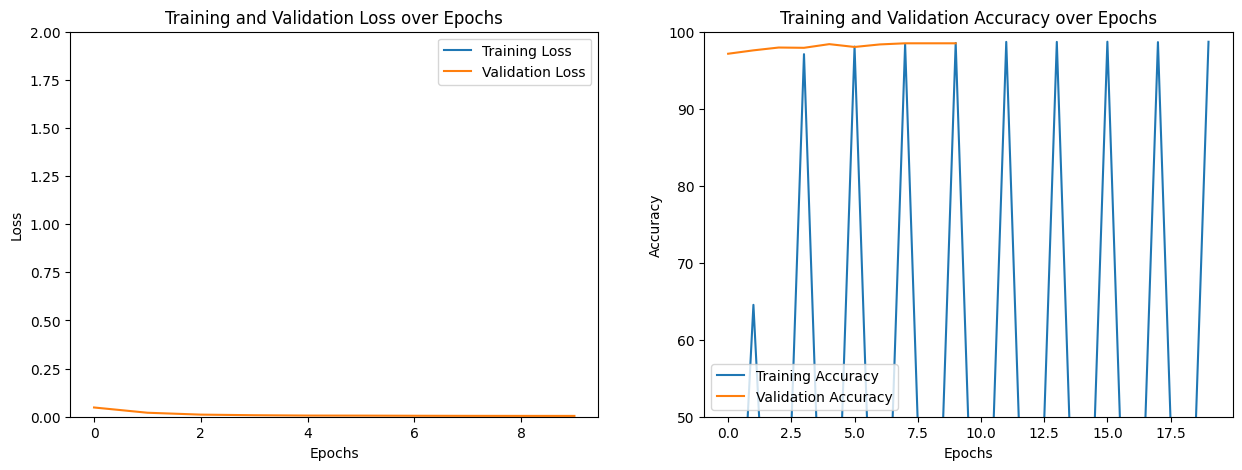

In [34]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axis[0].plot(total_loss_train_plot, label='Training Loss')
axis[0].plot(total_loss_validation_plot, label='Validation Loss')
axis[0].set_title('Training and Validation Loss over Epochs')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_ylim((0, 2))
axis[0].legend()

axis[1].plot(total_acc_train_plot, label='Training Accuracy')
axis[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy over Epochs')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].set_ylim((50, 100))
axis[1].legend()

plt.show()

In [29]:
Area = 3926/original_df['Area'].abs().max()

MajorAxisLength = 84/original_df['MajorAxisLength'].abs().max()

MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()

Eccentricity = 32/original_df['Eccentricity'].abs().max()

ConvexArea = 12/original_df['ConvexArea'].abs().max()

EquivDiameter = 33/original_df['EquivDiameter'].abs().max()

Extent = 98/original_df['Extent'].abs().max()

Perimeter = 927/original_df['Perimeter'].abs().max()

Roundness = 677/original_df['Roundness'].abs().max()

AspectRation = 24/original_df['AspectRation'].abs().max()



my_prediction = model(torch.tensor([Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation], dtype = torch.float32).to(device))


In [32]:
round(my_prediction.item())

0